In [ ]:
import tensorflow as tf
import shutil

In [ ]:
# Source directories in Google Drive
train_data_dir = '/content/drive/MyDrive/Colab Notebooks/Data/DECals/Data/Train Data'
test_data_dir = '/content/drive/MyDrive/Colab Notebooks/Data/DECals/Data/Test Data'

In [ ]:
# Destination directories on the local disk
destination_train_dir = '/content/Galaxy Data png/Train Data'
destination_test_dir = '/content/Galaxy Data png/Test Data'

In [ ]:
# Copy the train and test directories from Google Drive to the local disk
shutil.copytree(train_data_dir, destination_train_dir)
shutil.copytree(test_data_dir, destination_test_dir)

'/content/Galaxy Data png/Test Data'

In [ ]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import Dropout, Dense, Flatten

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
#Create generators for training and validation data
train_generator = train_datagen.flow_from_directory('/content/Galaxy Data png/Train Data',
                                                    target_size=(224, 224),
                                                    batch_size=64,
                                                    class_mode='categorical')

test_generator = validation_datagen.flow_from_directory('/content/Galaxy Data png/Test Data',
                                                              target_size=(224, 224),
                                                              batch_size=64,
                                                              class_mode='categorical',
                                                              shuffle=False)

Found 14185 images belonging to 10 classes.
Found 3551 images belonging to 10 classes.


In [ ]:
train_generator.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [ ]:
opt = SGD(lr=0.0001,momentum=0.7)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
for layers in ResNet50_model.layers:
    layers.trainable=True

In [ ]:
resnet_final_model = Sequential()
resnet_final_model.add(ResNet50_model)
resnet_final_model.add(Flatten())
resnet_final_model.add(Dense(256, activation = 'relu'))
resnet_final_model.add(Dense(128, activation = 'relu'))
resnet_final_model.add(Dense(64, activation = 'relu'))
resnet_final_model.add(Dense(10, activation='softmax'))

In [ ]:
resnet_final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 49,319,882
Trainable params: 49,266,762
No

In [ ]:
reduceLR = ReduceLROnPlateau(monitor='acc', factor=.001, patience=1, min_delta=0.01, mode="auto")

In [ ]:
resnet_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

In [ ]:
resnet50_history = resnet_final_model.fit(train_generator,
                                          steps_per_epoch=221,
                                          epochs = 20,
                                          validation_data = test_generator,
                                          validation_steps=55,
                                          verbose=1)

Epoch 1/20
221/221 [==============================] - 222s 916ms/step - loss: 1.9413 - acc: 0.3278 - val_loss: 13.5748 - val_acc: 0.0810
Epoch 2/20
221/221 [==============================] - 198s 892ms/step - loss: 1.3602 - acc: 0.5324 - val_loss: 12.7284 - val_acc: 0.0977
Epoch 3/20
221/221 [==============================] - 197s 890ms/step - loss: 1.1382 - acc: 0.6095 - val_loss: 10.8566 - val_acc: 0.1102
Epoch 4/20
221/221 [==============================] - 199s 897ms/step - loss: 1.0119 - acc: 0.6515 - val_loss: 6.6860 - val_acc: 0.1116
Epoch 5/20
221/221 [==============================] - 195s 880ms/step - loss: 0.9141 - acc: 0.6869 - val_loss: 1.9480 - val_acc: 0.3960
Epoch 6/20
221/221 [==============================] - 196s 885ms/step - loss: 0.8654 - acc: 0.7021 - val_loss: 0.9989 - val_acc: 0.6568
Epoch 7/20
221/221 [==============================] - 197s 888ms/step - loss: 0.8122 - acc: 0.7202 - val_loss: 0.8040 - val_acc: 0.7264
Epoch 8/20
221/221 [=========================

In [ ]:
# Evaluate the model on the test/validation data
loss, accuracy = resnet_final_model.evaluate(test_generator)
print("ResNet50 Test Loss:", loss)
print("ResNet50 Test Accuracy:", accuracy)

56/56 [==============================] - 16s 290ms/step - loss: 0.6939 - acc: 0.7705
ResNet50 Test Loss: 0.6939324140548706
ResNet50 Test Accuracy: 0.7704871892929077


In [ ]:
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']

In [ ]:
# Get the true labels and predictions for the test/validation data
true_labels = test_generator.classes
predictions_resnet = resnet_final_model.predict(test_generator).argmax(axis=1)

# Create the confusion matrix
cm = confusion_matrix(true_labels, predictions_resnet)
print("Confusion Matrix:")
print(cm)

56/56 [==============================] - 16s 270ms/step
Confusion Matrix:
[[109   2   7  17   1  18   6  45   8   4]
 [  6 315   3   3   0   5   8  23   5   3]
 [  4  28 447   0   0   5  32  13   0   0]
 [  4  23   6 335   2   6   8  17   0   5]
 [  2   0   0   6  45   2   2   2   4   4]
 [ 16  15   0   2   1 304  18  47   4   2]
 [  1   7  12   7   0   8 260  65   4   2]
 [ 80  24   4   8   0  34  67 296  11   2]
 [  0   2   0   0   0   1   3   3 272   4]
 [  2   3   0   0   1   0   0   0  16 353]]


In [ ]:
# Generate the classification report
resnet_classification_report = classification_report(true_labels, predictions_resnet)
print("Resnet Classification Report:")
print(resnet_classification_report)

Resnet Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.50      0.49       217
           1       0.75      0.85      0.80       371
           2       0.93      0.84      0.89       529
           3       0.89      0.83      0.85       406
           4       0.90      0.67      0.77        67
           5       0.79      0.74      0.77       409
           6       0.64      0.71      0.68       366
           7       0.58      0.56      0.57       526
           8       0.84      0.95      0.89       285
           9       0.93      0.94      0.94       375

    accuracy                           0.77      3551
   macro avg       0.77      0.76      0.76      3551
weighted avg       0.77      0.77      0.77      3551



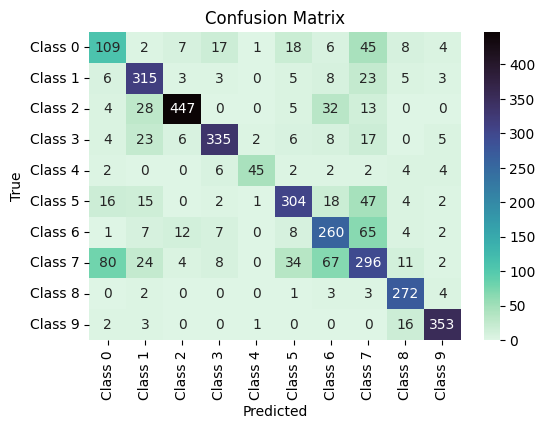

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='mako_r', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Get the training and validation accuracy values from the history object
training_acc_resnet = resnet50_history.history['acc']
val_acc_resnet = resnet50_history.history['val_acc']

# Get the training and validation loss values from the history object
training_loss_resnet = resnet50_history.history['loss']
val_loss_resnet = resnet50_history.history['val_loss']

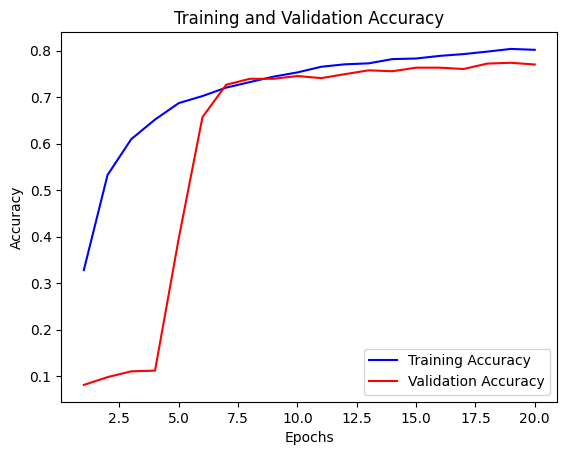

In [ ]:
# Plot the learning curve
epochs = range(1, len(training_acc_resnet) + 1)
plt.plot(epochs, training_acc_resnet, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc_resnet, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

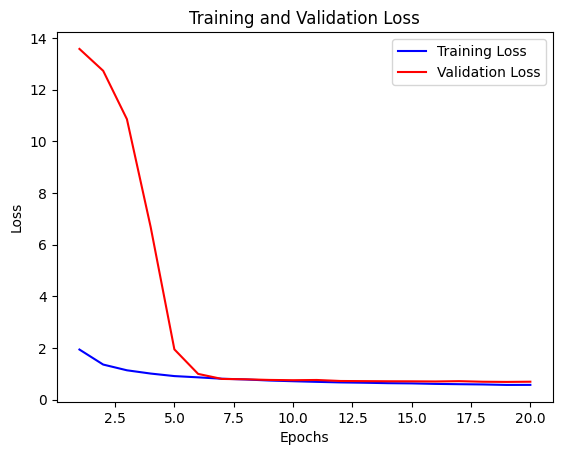

In [ ]:
plt.plot(epochs, training_loss_resnet, 'b', label='Training Loss')
plt.plot(epochs, val_loss_resnet, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Create generators for training and validation data
train_generator_inception = train_datagen.flow_from_directory('/content/Galaxy Data png/Train Data',
                                                               target_size=(299, 299),
                                                               batch_size=64,
                                                               class_mode='categorical')

test_generator_inception = validation_datagen.flow_from_directory('/content/Galaxy Data png/Test Data',
                                                                   target_size=(299, 299),
                                                                   batch_size=64,
                                                                   class_mode='categorical',
                                                                   shuffle=False)

Found 14185 images belonging to 10 classes.
Found 3551 images belonging to 10 classes.


In [ ]:
InceptionV3_model = InceptionV3(input_shape=(299,299,3),weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
for layers in InceptionV3_model.layers:
    layers.trainable=True

In [ ]:
InceptionV3_x_final_model = Sequential()
InceptionV3_x_final_model.add(InceptionV3_model)
InceptionV3_x_final_model.add(Flatten())
InceptionV3_x_final_model.add(Dense(256, activation = 'relu'))
InceptionV3_x_final_model.add(Dense(128, activation = 'relu'))
InceptionV3_x_final_model.add(Dense(64, activation = 'relu'))
InceptionV3_x_final_model.add(Dense(10, activation='softmax'))

In [ ]:
InceptionV3_x_final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               33554688  
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,399,274
Trainable params: 55,364,842


In [ ]:
InceptionV3_x_final_model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator_inception,
                                                    steps_per_epoch=221,
                                                    epochs = 20,
                                                    validation_data = test_generator_inception,
                                                    validation_steps=55,
                                                    verbose=1)

Epoch 1/20
221/221 [==============================] - 333s 1s/step - loss: 1.7072 - acc: 0.3791 - val_loss: 1.3324 - val_acc: 0.5188
Epoch 2/20
221/221 [==============================] - 305s 1s/step - loss: 1.0985 - acc: 0.6084 - val_loss: 0.9663 - val_acc: 0.6548
Epoch 3/20
221/221 [==============================] - 306s 1s/step - loss: 0.8898 - acc: 0.6903 - val_loss: 0.8404 - val_acc: 0.7057
Epoch 4/20
221/221 [==============================] - 306s 1s/step - loss: 0.7835 - acc: 0.7271 - val_loss: 0.7676 - val_acc: 0.7287
Epoch 5/20
221/221 [==============================] - 306s 1s/step - loss: 0.7120 - acc: 0.7555 - val_loss: 0.7565 - val_acc: 0.7381
Epoch 6/20
221/221 [==============================] - 305s 1s/step - loss: 0.6541 - acc: 0.7746 - val_loss: 0.6969 - val_acc: 0.7597
Epoch 7/20
221/221 [==============================] - 306s 1s/step - loss: 0.6170 - acc: 0.7880 - val_loss: 0.6652 - val_acc: 0.7702
Epoch 8/20
221/221 [==============================] - 305s 1s/step - 

In [ ]:
# Evaluate the model on the test/validation data
loss, accuracy = InceptionV3_x_final_model.evaluate(test_generator_inception)
print("InceptionV3 Test Loss:", loss)
print("InceptionV3 Test Accuracy:", accuracy)

56/56 [==============================] - 22s 383ms/step - loss: 0.6554 - acc: 0.7896
InceptionV3 Test Loss: 0.6553724408149719
InceptionV3 Test Accuracy: 0.7896367311477661


In [ ]:
# Get the true labels and predictions for the test/validation data
true_labels = test_generator.classes
predictions_Inception = InceptionV3_x_final_model.predict(test_generator_inception).argmax(axis=1)

# Create the confusion matrix
cm_inception = confusion_matrix(true_labels, predictions_Inception)
print("Confusion Matrix:")
print(cm_inception)

56/56 [==============================] - 19s 316ms/step
Confusion Matrix:
[[116   4  13  18   6  21  13  10  14   2]
 [  7 320   7   6   1   9   6   7   3   5]
 [  5  16 486   0   0   5  15   2   0   0]
 [  3  14   6 370   1   2   6   2   0   2]
 [  3   0   0   3  50   1   0   0   5   5]
 [ 14  20   0   4   2 341  14  12   2   0]
 [  4   4  25  12   0  13 290  10   6   2]
 [122  36  15  10   3  38  95 196  11   0]
 [  3   1   0   0   0   0   1   0 278   2]
 [  1   3   0   0   2   0   0   0  12 357]]


In [ ]:
# Generate the classification report
inception_classification_report = classification_report(true_labels, predictions_Inception)
print("Inception Classification Report:")
print(inception_classification_report)

Inception Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.53      0.47       217
           1       0.77      0.86      0.81       371
           2       0.88      0.92      0.90       529
           3       0.87      0.91      0.89       406
           4       0.77      0.75      0.76        67
           5       0.79      0.83      0.81       409
           6       0.66      0.79      0.72       366
           7       0.82      0.37      0.51       526
           8       0.84      0.98      0.90       285
           9       0.95      0.95      0.95       375

    accuracy                           0.79      3551
   macro avg       0.78      0.79      0.77      3551
weighted avg       0.80      0.79      0.78      3551



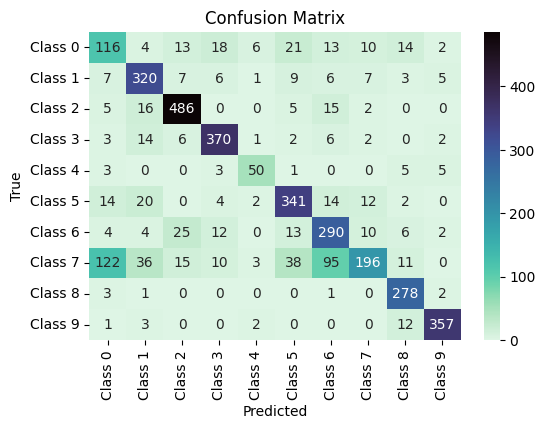

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_inception, annot=True, fmt='d', cmap='mako_r', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Get the training and validation accuracy values from the history object
training_acc_inception = inceptionv3_history.history['acc']
val_acc_inception = inceptionv3_history.history['val_acc']

# Get the training and validation loss values from the history object
training_loss_inception = inceptionv3_history.history['loss']
val_loss_inception = inceptionv3_history.history['val_loss']

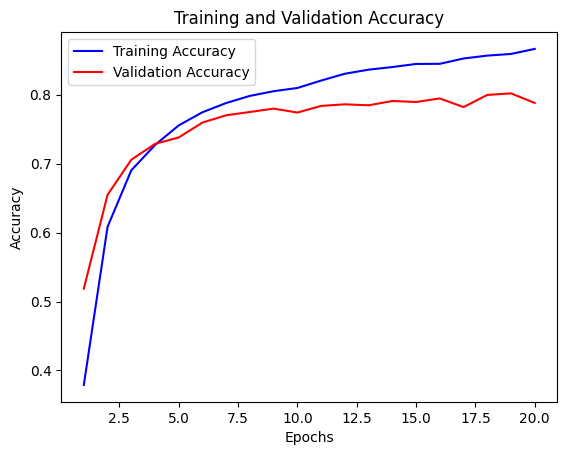

In [ ]:
# Plot the learning curve
epochs = range(1, len(training_acc_inception) + 1)
plt.plot(epochs, training_acc_inception, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc_inception, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

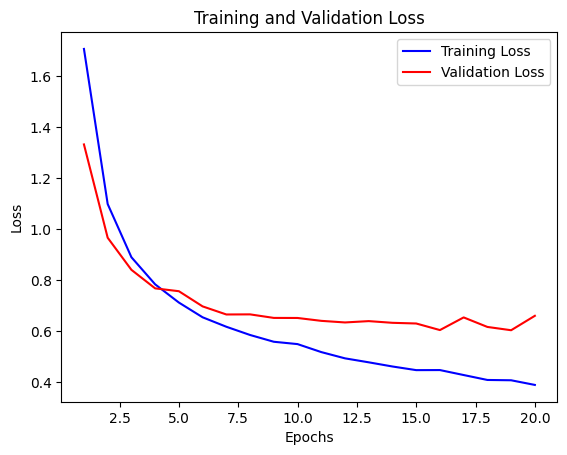

In [ ]:
plt.plot(epochs, training_loss_inception, 'b', label='Training Loss')
plt.plot(epochs, val_loss_inception, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model

In [ ]:
resnet_final_model.save('/content/drive/MyDrive/Colab Notebooks/Data/DECals/CNN Models/Final Models/ResNet50/resnet_final_model.h5')

In [ ]:
InceptionV3_x_final_model.save('/content/drive/MyDrive/Colab Notebooks/Data/DECals/CNN Models/Final Models/InceptionV3/inception_final_model.h5')

In [ ]:
vgg16_model_2 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
for layers in vgg16_model_2.layers:
            layers.trainable=True

In [ ]:
vgg16_model_2_final_model = Sequential()
vgg16_model_2_final_model.add(vgg16_model_2)
vgg16_model_2_final_model.add(Flatten())
vgg16_model_2_final_model.add(Dense(256, activation = 'relu'))
vgg16_model_2_final_model.add(Dense(128, activation = 'relu'))
vgg16_model_2_final_model.add(Dense(64, activation = 'relu'))
vgg16_model_2_final_model.add(Dense(10, activation='softmax'))

In [ ]:
vgg16_model_2_final_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               6422784   
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 21,179,274
Trainable params: 21,179,274


In [ ]:
vgg16_model_2_final_model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
vgg16_model_2_history = vgg16_model_2_final_model.fit(train_generator,
                                                      steps_per_epoch=221,
                                                      epochs = 20,
                                                      validation_data = test_generator,
                                                      validation_steps=55,
                                                      verbose=1)

Epoch 1/20
221/221 [==============================] - 241s 982ms/step - loss: 2.1311 - acc: 0.2277 - val_loss: 1.8845 - val_acc: 0.3094
Epoch 2/20
221/221 [==============================] - 202s 912ms/step - loss: 1.5045 - acc: 0.4634 - val_loss: 1.3011 - val_acc: 0.5111
Epoch 3/20
221/221 [==============================] - 202s 912ms/step - loss: 1.1400 - acc: 0.5928 - val_loss: 1.0679 - val_acc: 0.6085
Epoch 4/20
221/221 [==============================] - 202s 912ms/step - loss: 0.9625 - acc: 0.6628 - val_loss: 0.9599 - val_acc: 0.6500
Epoch 5/20
221/221 [==============================] - 202s 909ms/step - loss: 0.8724 - acc: 0.7011 - val_loss: 0.8777 - val_acc: 0.6787
Epoch 6/20
221/221 [==============================] - 202s 912ms/step - loss: 0.7832 - acc: 0.7283 - val_loss: 0.7353 - val_acc: 0.7386
Epoch 7/20
221/221 [==============================] - 203s 914ms/step - loss: 0.7344 - acc: 0.7500 - val_loss: 0.7005 - val_acc: 0.7506
Epoch 8/20
221/221 [============================

In [ ]:
# Evaluate the model on the test/validation data
loss, accuracy = vgg16_model_2_final_model.evaluate(test_generator)
print("VGG16 Test Loss:", loss)
print("VGG16 Test Accuracy:", accuracy)

56/56 [==============================] - 21s 366ms/step - loss: 0.5215 - acc: 0.8186
VGG16 Test Loss: 0.5214952826499939
VGG16 Test Accuracy: 0.8186426162719727


In [ ]:
# Get the true labels and predictions for the test/validation data
true_labels = test_generator.classes
predictions_vgg16 = vgg16_model_2_final_model.predict(test_generator).argmax(axis=1)

# Create the confusion matrix
cm_vgg = confusion_matrix(true_labels, predictions_vgg16)
print("Confusion Matrix:")
print(cm_vgg)

56/56 [==============================] - 16s 281ms/step
Confusion Matrix:
[[102   3  13  17   3  12   7  48  10   2]
 [ 11 305   6   3   1   5   8  27   2   3]
 [  3  11 495   0   0   4  15   1   0   0]
 [  3   6   2 380   0   1   7   7   0   0]
 [  1   0   0   8  50   0   1   0   5   2]
 [  9  14   1   3   0 335  14  31   2   0]
 [  1   5  33  11   0   3 269  38   4   2]
 [ 39  16  11   8   0  25  63 354   8   2]
 [  1   1   0   0   0   1   0   5 272   5]
 [  1   3   0   0   1   0   0   2  23 345]]


In [ ]:
# Generate the classification report
vgg_classification_report = classification_report(true_labels, predictions_vgg16)
print("VGG16 Classification Report:")
print(vgg_classification_report)

VGG16 Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.47      0.53       217
           1       0.84      0.82      0.83       371
           2       0.88      0.94      0.91       529
           3       0.88      0.94      0.91       406
           4       0.91      0.75      0.82        67
           5       0.87      0.82      0.84       409
           6       0.70      0.73      0.72       366
           7       0.69      0.67      0.68       526
           8       0.83      0.95      0.89       285
           9       0.96      0.92      0.94       375

    accuracy                           0.82      3551
   macro avg       0.82      0.80      0.81      3551
weighted avg       0.82      0.82      0.82      3551



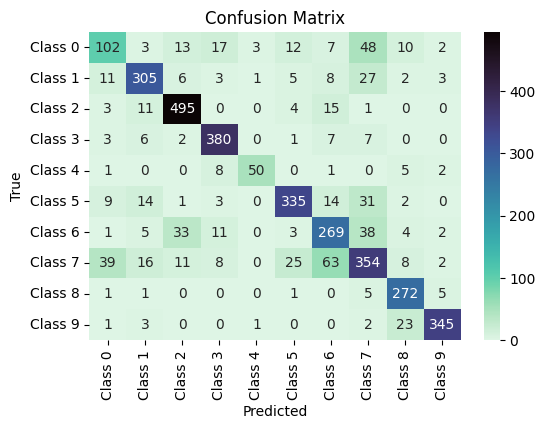

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='mako_r', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Get the training and validation accuracy values from the history object
training_acc_vgg = vgg16_model_2_history.history['acc']
val_acc_vgg = vgg16_model_2_history.history['val_acc']

# Get the training and validation loss values from the history object
training_loss_vgg = vgg16_model_2_history.history['loss']
val_loss_vgg = vgg16_model_2_history.history['val_loss']

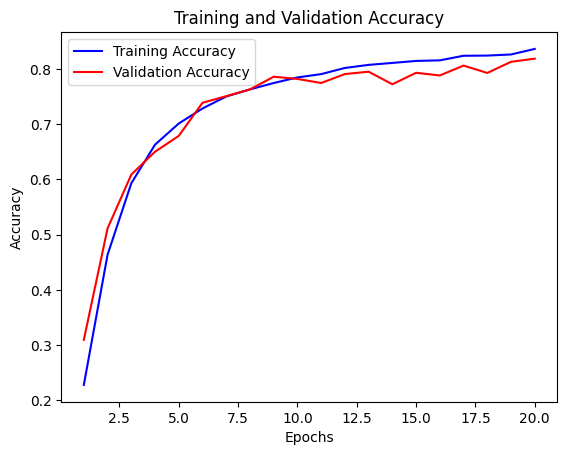

In [ ]:
# Plot the learning curve
epochs = range(1, len(training_acc_vgg) + 1)
plt.plot(epochs, training_acc_vgg, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc_vgg, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

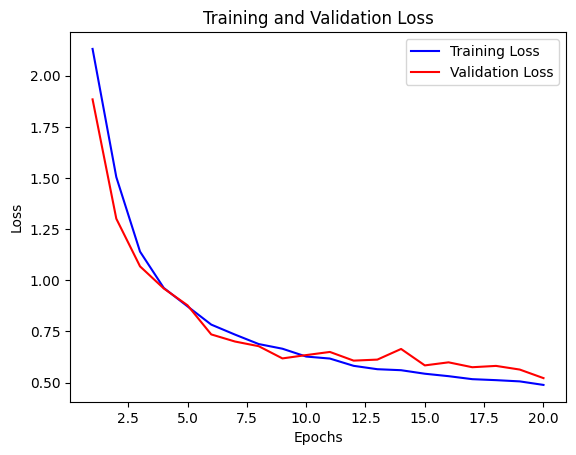

In [ ]:
plt.plot(epochs, training_loss_vgg, 'b', label='Training Loss')
plt.plot(epochs, val_loss_vgg, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
vgg16_model_2_final_model.save('/content/drive/MyDrive/Colab Notebooks/Data/DECals/CNN Models/Final Models/VGG16/vgg_final_model.h5')

In [ ]:
predictions_vgg16

array([7, 7, 0, ..., 9, 9, 9])

In [ ]:
predictions_resnet

array([0, 7, 0, ..., 9, 9, 9])

In [ ]:
predictions_Inception

array([0, 6, 0, ..., 9, 9, 9])

In [ ]:
# Create the ensemble predictions using custom logic
ensemble_predictions = []

for i in range(len(predictions_vgg16)):
    ensemble_prediction = [predictions_vgg16[i], predictions_resnet[i], predictions_Inception[i]]

    # Check if there's a majority vote
    majority_vote = np.argmax(np.bincount(ensemble_prediction))

    # Check if all predictions are different
    if len(set(ensemble_prediction)) == 3:
        ensemble_predictions.append(predictions_vgg16[i])  # Fallback to VGG-16
    else:
        ensemble_predictions.append(majority_vote)

# Convert the ensemble predictions to a numpy array
ensemble_predictions = np.array(ensemble_predictions)

In [ ]:
# Generate the classification report
ensemble_classification_report = classification_report(true_labels, ensemble_predictions)
print("Ensemble Classification Report:")
print(ensemble_classification_report)

Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.53      0.54       217
           1       0.81      0.87      0.84       371
           2       0.90      0.91      0.91       529
           3       0.88      0.92      0.90       406
           4       0.89      0.75      0.81        67
           5       0.85      0.84      0.84       409
           6       0.69      0.78      0.73       366
           7       0.72      0.59      0.65       526
           8       0.86      0.97      0.91       285
           9       0.96      0.95      0.96       375

    accuracy                           0.82      3551
   macro avg       0.81      0.81      0.81      3551
weighted avg       0.82      0.82      0.82      3551



In [ ]:
# Generate the confusion matrix
cm_ensemble = confusion_matrix(true_labels, ensemble_predictions)

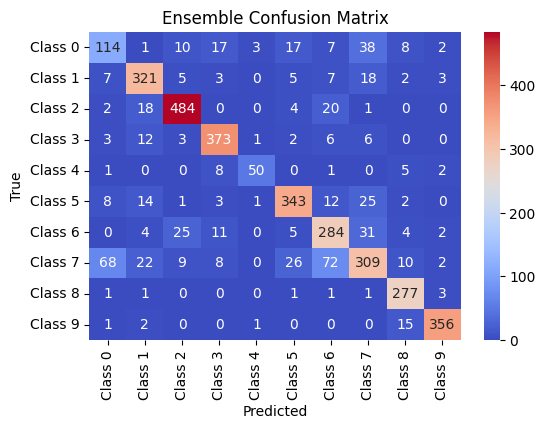

In [ ]:
# Plot the confusion matrix
palette = "coolwarm"

plt.figure(figsize=(6, 4))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap=palette, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ensemble Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, ensemble_predictions)
print(f"Ensemble Model Accuracy: {accuracy}")

Ensemble Model Accuracy: 0.8197690791326387
